In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import math

In [86]:
pop=pd.read_csv('/Users/yuanfan/Documents/COVID-19/data/province_population.csv')
pop=pop[:31].sort_values('province_cn')
pop

,province_en,pop_18_m,province_cn
8,Shanghai,24240000.0,上海
24,Yunnan,48300000.0,云南
4,Inner Mongolia,25340000.0,内蒙古
0,Beijing,21540000.0,北京
6,Jilin,27040000.0,吉林
22,Sichuan,83410000.0,四川
1,Tianjin,15600000.0,天津
29,Ningxia,6880000.0,宁夏
11,Anhui,63240000.0,安徽
14,Shandong,100470000.0,山东


In [8]:
immi=pd.read_csv('/Users/yuanfan/Documents/COVID-19/resource/transit/Baidu_Immig_20200101-20200202.csv', encoding='gb2312')

In [10]:
def cleanprovince(provincename):
    if type(provincename)!=float:
        name=provincename.replace('市','')
        name=name.replace('省','')
        return name
    else:
        return None

In [13]:
location=pd.read_csv('/Users/yuanfan/Documents/COVID-19/data/ChinaCitieswithlocation20200130final_xyz.csv')
location['city_name']=location['city'].apply(lambda x: x.replace('市', '') if type(x)!=float else None)
location['province_clean']=location['province'].apply(cleanprovince)
geocode=location[['lat','lng','city_name']].groupby('city_name').max().reset_index()
geocode

,city_name,lat,lng
0,七台河,45.81597,131.06693
1,万宁,18.79532,110.38975
2,三亚,18.40005,109.75250
3,三明,26.90012,118.19049
4,三沙,16.83272,112.33356
...,...,...,...
364,黔东南苗族侗族自治州,27.17385,109.20776
365,黔南布依族苗族自治州,27.07790,107.88732
366,黔西南布依族苗族自治州,25.83474,106.09962
367,齐齐哈尔,48.48419,126.24871


In [14]:
pckey=location[['province_clean','city_name']]
pckey

,province_clean,city_name
0,上海,上海
1,上海,上海
2,上海,上海
3,上海,上海
4,上海,上海
...,...,...
3241,安徽,六安
3242,广西壮族自治区,贺州
3243,江苏,无锡
3244,新疆维吾尔自治区,昆玉


In [25]:
def cleanmobility(file):
    df=file.copy()
    df.rename(columns={'迁出城市':'from_city','迁入城市':'to_city','日期':'time','人数':'quantity' }, inplace=True)
    df['time']=df['time'].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
    df['time']=pd.to_datetime(df['time'])
    df['from_city']=df['from_city'].apply(lambda x: x.replace('市', '') if type(x)!=float else None)
    df['to_city']=df['to_city'].apply(lambda x: x.replace('市', '') if type(x)!=float else None)
    

#     df=df[['from_city', 'to_city', 'time', 'quantity', 'from_city',
#        'from_lat', 'from_lon', 'to_city', 'to_lat', 'to_lon','from_province',  'to_province']].drop_duplicates()

    return df

In [29]:
def joingeo(file):
    df=file.copy()
    df=df.merge(geocode, left_on='from_city',right_on='city_name', how='left')
    df=df.merge(geocode, left_on='to_city',right_on='city_name', how='left')
    df.rename(columns={'city_x':'from_city','city_y':'to_city','lng_x':'from_lon','lat_x':'from_lat',
              'lng_y':'to_lon','lat_y':'to_lat'}, inplace=True)
    return df

In [44]:
def mergeprovince(file): 
    df=file.copy()
    df=df.merge(pckey, left_on ='to_city',right_on='city_name', how ='left')
    df=df.merge(pckey, left_on ='from_city',right_on='city_name', how ='left')
    df.rename(columns={'province_clean_x':'from_province','province_clean_y':'to_province'}, inplace=True)
    return df

In [27]:
immiDF=cleanmobility(immi)
immiDFF=joingeo(immiDF)
immi_provDFF=mergeprovince(immiDFF)

In [200]:
immi_provDFF.head()

,from_city,to_city,比例,quantity,time,city_name_x,from_lat,from_lon,city_name_y,to_lat,to_lon,from_province,city_name_x,to_province,city_name_y
0,北京,廊坊,18.63,11803.14977,2020-01-01,北京,40.45678,117.12141,廊坊,39.98246,117.07822,河北,廊坊,北京,北京
1,北京,廊坊,18.63,11803.14977,2020-01-01,北京,40.45678,117.12141,廊坊,39.98246,117.07822,河北,廊坊,北京,北京
2,北京,廊坊,18.63,11803.14977,2020-01-01,北京,40.45678,117.12141,廊坊,39.98246,117.07822,河北,廊坊,北京,北京
3,北京,廊坊,18.63,11803.14977,2020-01-01,北京,40.45678,117.12141,廊坊,39.98246,117.07822,河北,廊坊,北京,北京
4,北京,廊坊,18.63,11803.14977,2020-01-01,北京,40.45678,117.12141,廊坊,39.98246,117.07822,河北,廊坊,北京,北京


In [225]:
immi_provDFF2=immi_provDFF.drop_duplicates(subset=['from_city','to_city','time']).fillna({'quantity':0})
provincedf=immi_provDFF2.groupby(['from_province','to_province','time']).agg({'quantity':'sum',
                                                                      'from_lat':'mean',
                                                                      'to_lat':'mean',
                                                                      'from_lon':'mean',
                                                                      'to_lon':'mean'}).reset_index()


In [204]:
provincedf.to_csv('/Users/yuanfan/Documents/COVID-19/resource/transit/Baidu_province.csv')

### Create a matrix

In [79]:
oneday_mobility=provincedf[provincedf['time']=='2020-01-15']

oneday_mobility=oneday_mobility.drop_duplicates(subset=['from_province','to_province'])
oneday_mobility=oneday_mobility[oneday_mobility['from_province']!=oneday_mobility['to_province']]
OD_matrix=oneday_mobility.pivot(index='from_province',columns='to_province',values='quantity')
OD_simulate=OD_matrix.interpolate()

In [80]:
OD_simulate

to_province,上海,云南,内蒙古自治区,北京,吉林,四川,天津,宁夏回族自治区,安徽,山东,...,湖南,甘肃,福建,西藏自治区,贵州,辽宁,重庆,陕西,青海,黑龙江
from_province,,,,,,,,,,,,,,,,,,,,,
上海,NaN,251.445287,160.243110,2352.093714,289.566155,810.953662,421.846056,98.904110,4969.559822,2296.499818,...,554.908417,203.584234,1205.177713,15.125227,194.057726,612.430114,464.547636,603.936162,33.118049,373.059756
云南,366.680779,304.599679,43.966314,501.461604,45.094514,4989.065108,103.117925,34.580131,197.667022,411.279541,...,424.158606,51.852344,1039.333000,146.015622,5297.817766,102.110609,1170.849654,199.814299,17.830822,61.493807
内蒙古自治区,1477.507846,357.754072,1505.118980,3211.742178,1733.640052,1.077268,876.502361,1720.826046,5.631120,361.277399,...,642.539887,558.962921,907.982152,2.514532,2792.353095,3699.290639,903.023721,2670.997096,6.125155,2109.738215
北京,2588.334912,410.908464,2966.271646,2202.849189,998.609116,1443.165530,6360.501089,294.906938,1245.361716,6292.773522,...,860.921168,441.991145,776.631305,41.476471,286.888424,2614.536274,635.197788,1565.402436,128.894911,1459.814076
吉林,269.618220,7.510709,2030.193526,1193.956200,548.659883,73.196525,773.384436,233.074357,49.333406,1195.656811,...,54.063612,5.682150,40.880376,0.816674,2936.080062,5636.958448,12125.641356,7.912372,231.295597,4080.243229
四川,2297.147234,8303.862906,147.493872,1910.329920,98.710650,152.650462,262.481990,171.241776,378.967928,1403.660340,...,802.008184,1298.959092,5201.014374,1419.750666,5585.271700,361.018328,23616.084924,3744.560729,333.696283,188.687815
天津,474.528067,87.298625,500.465174,5444.440272,307.618852,232.104398,601.521228,40.668415,265.309441,2742.999552,...,111.687174,99.576767,164.980800,4.706975,27.622328,827.675431,123.247332,311.929348,15.795518,443.552760
宁夏回族自治区,8708.668506,128.995902,1590.638764,322.368174,7.361345,89.581594,940.560466,116.235405,982.747588,18.378382,...,301.214878,1641.244129,1338.168827,6.703528,80.159722,735.785321,165.909870,1572.850548,60.640618,0.816091
安徽,16942.808945,170.693179,256.455752,2638.643202,145.621638,267.762672,1279.599703,191.802395,1700.185734,4126.575683,...,490.742582,195.623813,2511.356854,36.322085,132.697116,643.895212,208.572408,1107.459896,110.047507,161.903707


## Plug in the model

In [87]:
#pop
len(pop.province_cn.unique())

31

In [183]:
#Parameter β represents the rate of conversion from “susceptable” to “exposed”
beta= 0.8
#from "exposed" to "infected" with a rate of α: alpha
alpha=1/5 #This could change per serious of the disease

#Parameter γ determines the rate of recovery, 
#while the recovered subjects are removed from the repository of susceptible subjects. y for gamma
gamma= 0.135

R0=beta/gamma

mobility_factor=1 #adjust this to control inflow out flow
max_hospital=10000# assume 10000 people could be in hospital
R0


5.925925925925926

In [237]:
def SEIR_Model(seir,OD_matrixDF):
    seir_previous=seir.copy()
    flow_infected_matrix=OD_matrixDF*mobility_factor/Nc * seir_previous[:,2]
    inflow_infected_sum=flow_infected_matrix.sum(axis=1)
    total_infected=seir_previous[:,2]+inflow_infected_sum
    
    new_S=-1*beta*(total_infected)*seir_previous[:,0]/Nc
    new_E=beta*(total_infected)*seir_previous[:,0]/Nc - alpha* seir_previous[:,1]
    new_I = alpha*seir_previous[:,1] - gamma*seir_previous[:,2]
    new_R = gamma*seir_previous[:,2] 
    
    seir[:,0]=seir[:,0]+new_S
    seir[:,1]=seir[:,1]+new_E
    seir[:,2]=seir[:,2]+new_I
    seir[:,3]=seir[:,3]+new_R
    
    return seir

In [253]:
T=200
#innitiate initial
Nc=pop['pop_18_m'].values.T#population of different province
SEIR=np.zeros([len(pop.province_cn.unique()),4])
SEIR[:,0]=Nc
first_infections=np.where(SEIR[:, 0]==59170000,10,0)
SEIR[:, 0] = SEIR[:, 0] - first_infections # suscepticles -1
SEIR[:, 1] = SEIR[:, 1] + first_infections*10 #
SEIR[:, 2] = SEIR[:, 2] + first_infections# move infections to the I group


OD_matrixDF=OD_simulate.copy()
output=pd.DataFrame({"day":[],"province":[],"susceptics":[],"exposed":[],"infected":[],"recover":[]})
provincelist=pop.province_cn.unique()
for i in range(T):
    SEIR=SEIR_Model(SEIR,OD_matrixDF)
    day=np.full(len(provincelist),i)
    new=pd.DataFrame({"day":day,"province":provincelist,"susceptics": SEIR[:,0],
                  "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3]})
    output=pd.concat([output,new], sort=False)
output.tail()

,day,province,susceptics,exposed,infected,recover
26,199.0,辽宁,65803.977412,14.902871,824.515939,4.352336e+07
27,199.0,重庆,46317.812404,0.690162,39.053290,3.097364e+07
28,199.0,陕西,58258.850501,2.052434,115.423482,3.858162e+07
29,199.0,青海,9003.007253,0.139484,7.816386,6.020989e+06
30,199.0,黑龙江,57088.186381,9.862126,546.450233,3.767236e+07


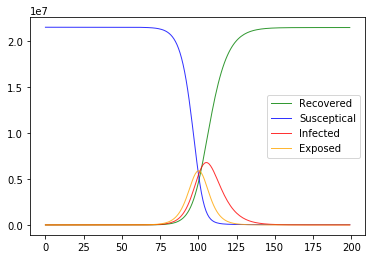

In [254]:
sh=output[output['province']=='北京']
plt.plot(sh['day'],sh['recover'], marker='', color='green', linewidth=1, alpha=0.8, label='Recovered')
plt.plot(sh['day'],sh['susceptics'], marker='', color='blue', linewidth=1, alpha=0.8, label='Susceptical')
plt.plot(sh['day'],sh['infected'], marker='', color='red', linewidth=1, alpha=0.8, label='Infected')
plt.plot(sh['day'],sh['exposed'], marker='', color='orange', linewidth=1, alpha=0.8, label='Exposed')
plt.legend()

In [157]:
temp.columns

Index(['day', 'province', 'susceptics', 'exposed', 'infected', 'recover',
       'from_province', 'from_lat', 'from_lon'],
      dtype='object')

In [262]:
geo=provincedf.drop_duplicates(subset=['to_province'])


In [256]:
geo=geo[['to_province','from_lat','from_lon']].reset_index()

In [257]:
temp=output.merge(geo,left_on='province',right_on='to_province', how='left')
temp[['day', 'province', 'susceptics', 'exposed', 'infected', 'recover','from_lat', 'from_lon']]

,day,province,susceptics,exposed,infected,recover,from_lat,from_lon
0,0.0,上海,2.424000e+07,1.305094e-04,0.000000,0.000000e+00,31.622900,121.544090
1,0.0,云南,4.830000e+07,3.560962e-05,0.000000,0.000000e+00,25.904380,102.305075
2,0.0,内蒙古,2.534000e+07,1.022356e-04,0.000000,0.000000e+00,NaN,NaN
3,0.0,北京,2.154000e+07,1.688615e-04,0.000000,0.000000e+00,40.456780,117.121410
4,0.0,吉林,2.704000e+07,2.943893e-07,0.000000,0.000000e+00,43.973113,126.181140
...,...,...,...,...,...,...,...,...
6195,199.0,辽宁,6.580398e+04,1.490287e+01,824.515939,4.352336e+07,41.509194,123.150248
6196,199.0,重庆,4.631781e+04,6.901622e-01,39.053290,3.097364e+07,31.947670,109.878800
6197,199.0,陕西,5.825885e+04,2.052434e+00,115.423482,3.858162e+07,35.282599,109.596947
6198,199.0,青海,9.003007e+03,1.394842e-01,7.816386,6.020989e+06,36.885530,102.317030


In [258]:
temp2=temp.drop_duplicates(subset=['day','province','exposed','infected','recover'])

In [259]:
temp2[temp2['province']=='北京']

,day,province,susceptics,exposed,infected,recover,index,to_province,from_lat,from_lon
3,0.0,北京,2.154000e+07,0.000169,0.000000,0.000000e+00,66.0,北京,40.45678,117.12141
34,1.0,北京,2.154000e+07,0.000619,0.000034,0.000000e+00,66.0,北京,40.45678,117.12141
65,2.0,北京,2.154000e+07,0.001238,0.000153,4.559261e-06,66.0,北京,40.45678,117.12141
96,3.0,北京,2.154000e+07,0.002047,0.000380,2.521272e-05,66.0,北京,40.45678,117.12141
127,4.0,北京,2.154000e+07,0.003117,0.000738,7.649942e-05,66.0,北京,40.45678,117.12141
...,...,...,...,...,...,...,...,...,...,...
6048,195.0,北京,3.179300e+04,1.424898,80.854421,2.150812e+07,66.0,北京,40.45678,117.12141
6079,196.0,北京,3.179290e+04,1.236595,70.224054,2.150814e+07,66.0,北京,40.45678,117.12141
6110,197.0,北京,3.179282e+04,1.073241,60.991126,2.150815e+07,66.0,北京,40.45678,117.12141
6141,198.0,北京,3.179275e+04,0.931519,52.971972,2.150815e+07,66.0,北京,40.45678,117.12141


In [260]:
temp[['susceptics','exposed','infected']]=temp[['susceptics','exposed','infected']].apply(lambda x: round(x,2))

In [233]:
temp2[(temp['day']<150) & (temp['day']>50)].to_csv('test.csv')

In [261]:
temp2[['day', 'province', 'susceptics', 'exposed', 'infected', 'recover','from_lat', 'from_lon']].to_csv('/Users/yuanfan/Documents/COVID-19/output/modeloutput0217.csv')